# Orthogonal vs Parallel Manifolds in the four context case


In [1]:
import torch
import torch.nn.functional as F
from torch import optim
from scipy.spatial.distance import squareform, pdist
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import *
from sklearn.manifold import MDS
from more_itertools import distinct_permutations
from sklearn import linear_model
import pickle

In [10]:
# define parameters 
# Neural Network
N_HIDDEN = 1000
SIGMA_IN_STIM = 1e-8
SIGMA_IN_CTX = 5e-1 #5e-1 # separate weight for context info
SIGMA_HIDDEN = 1/(N_HIDDEN**.5)
SIGMA_OUT = 1/(N_HIDDEN**.5)

# Optimisation
LRATE = 1e-2 #1e-2 # was 5e-2 for 1k hidden
N_ITER = 5000 # was 5k for 1k hidden
MONITOR_CMD = True # if true, print stats to command line\
MONITOR_ITERS = 1000 # print each x iters to cmd
num_runs = 10  #number of independent runs
epsilon = 0.1

In [3]:
def mk_block(feature='dangerousness'):
    """
    generates single block of 50 trials 
    x: 50x24 (5 lvls of dangerousness, 5 lvls of size, 2 possible tasks, 2 possible stim sets)
    y: 50x1 (predicted value is continuous, 1 to 5)
    
    """
    
    d,s = np.meshgrid(np.arange(5),np.arange(5))
    d = d.flatten()
    s = s.flatten()
    x = np.zeros((50,24))

    for ii in range(len(d)):
        x[ii,d[ii]] = 1
        x[ii,s[ii]+5] = 1
        x[ii,d[ii]+10] = 1
        x[ii,s[ii]+15] = 1
    for ii in range(len(d)):
        x[ii+25,d[ii]] = 1
        x[ii+25,s[ii]+5] = 1
        x[ii+25,d[ii]+10] = 1
        x[ii+25,s[ii]+15] = 1
    if feature=='dangerousness':
        y = d-np.mean(d) 
        x[:,20] = 1
    elif feature=='size':
        y = s-np.mean(s)
        x[:,21] = 1
        
    x[:25,22] = 1
    x[25:,23] = 1
    y = np.concatenate((y,y), axis=0)
    
    return x.astype(np.float32),y[:,np.newaxis].astype(np.float32)
    

def mk_experiment(training_type='interleaved'):
    # one block per task:
    x1,y1 = mk_block('dangerousness')
    x2,y2 = mk_block('size')
    x = np.concatenate((x1,x2),axis=0)
    y = np.concatenate((y1,y2),axis=0)
    #print(x.shape)
    # test data doesn't have to be shuffled
    x_test = x
    y_test = y
    
    # shuffle training data
    if training_type == 'interleaved':
        ii_shuff = np.random.permutation(100)
        x_train = x[ii_shuff,:]
        y_train = y[ii_shuff,]
    elif training_type == 'blocked':
        #ii_shuff - np.random.permutation(4) #default order is da, db, sa, sb
        #da = x[:25,:]
        #db = x
        x_train = x
        y_train = y
    return x_train,y_train, x_test,y_test

def mk_experiment_rand(training_type='interleaved'):
    rand_mat = np.random.choice([0,1], [50,50])
    Q, R = np.linalg.qr(rand_mat)
    x = Q.T
    x = np.concatenate([x,x])

    context_1 = np.concatenate([np.zeros(50), np.ones(50)])
    context_2 = np.concatenate([np.ones(50), np.zeros(50)])
    context_3 = np.concatenate([np.ones(25),np.zeros(25),np.ones(25),np.zeros(25)])
    context_4 = np.concatenate([np.zeros(25),np.ones(25),np.zeros(25),np.ones(25)])
    context_1 = context_1[:,np.newaxis]
    context_2 = context_2[:,np.newaxis]
    context_3 = context_3[:,np.newaxis]
    context_4 = context_4[:,np.newaxis]

    x = np.concatenate([x, context_1, context_2, context_3, context_4], axis=1)

    d,s = np.meshgrid(np.arange(5),np.arange(5))
    d = d.flatten()
    s = s.flatten()
    y_d= d-np.mean(d)
    y_s = s-np.mean(s)
    y = np.concatenate([y_d, y_d, y_s, y_s])
    y = y[:, np.newaxis]

    x = x.astype(np.float32)
    y = y.astype(np.float32)

    x_test = x
    y_test = y

    if training_type == 'interleaved':
        ii_shuff = np.random.permutation(100)
        x_train = x[ii_shuff,:]
        y_train = y[ii_shuff,]
    elif training_type == 'blocked':
        x_train = x
        y_train = y
    return x_train,y_train, x_test,y_test

def mk_experiment_hierach(epislon, training_type='blocked'):
    grand_parent = np.random.choice([0, 1], [1,50])
    animals_parent = generate_daughter(grand_parent, epsilon)
    objects_parent = generate_daughter(grand_parent, epsilon)
    animals = np.zeros([25,50])
    objects = np.zeros([25,50])
    for i in range(25):
        animals[i,:] = generate_daughter(animals_parent, epsilon)
        objects[i,:] = generate_daughter(objects_parent, epsilon)
    x= np.concatenate([animals,objects])
    x = np.concatenate([x,x])
    
    context_1 = np.concatenate([np.zeros(50), np.ones(50)])
    context_2 = np.concatenate([np.ones(50), np.zeros(50)])
    context_3 = np.concatenate([np.ones(25),np.zeros(25),np.ones(25),np.zeros(25)])
    context_4 = np.concatenate([np.zeros(25),np.ones(25),np.zeros(25),np.ones(25)])
    context_1 = context_1[:,np.newaxis]
    context_2 = context_2[:,np.newaxis]
    context_3 = context_3[:,np.newaxis]
    context_4 = context_4[:,np.newaxis]

    x = np.concatenate([x, context_1, context_2, context_3, context_4], axis=1)

    d,s = np.meshgrid(np.arange(5),np.arange(5))
    d = d.flatten()
    s = s.flatten()
    y_d= d-np.mean(d)
    y_s = s-np.mean(s)
    y = np.concatenate([y_d, y_d, y_s, y_s])
    y = y[:, np.newaxis]

    x = x.astype(np.float32)
    y = y.astype(np.float32)

    x_test = x
    y_test = y

    if training_type == 'interleaved':
        ii_shuff = np.random.permutation(100)
        x_train = x[ii_shuff,:]
        y_train = y[ii_shuff,]
    elif training_type == 'blocked':
        x_train = x
        y_train = y
    return x_train,y_train, x_test,y_test
    
    
def generate_daughter(parent, epsilon=0.1):
    daughter_idx = np.random.choice([0,1], [1,50], [1-epsilon, epsilon])
    daughter = parent
    for ii in range(50):
        if daughter_idx[0,ii] ==1:
            if daughter[0,ii]==1:
                daughter[0,ii] = 0
            else:
                daughter[0,ii]=1
    return daughter

In [4]:
class Nnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # input weights
        self.w_h1x = torch.nn.Parameter(torch.randn(50,N_HIDDEN)*SIGMA_IN_STIM)
        self.b_h1 = torch.nn.Parameter(torch.zeros(N_HIDDEN))        
        # context weights
        self.w_h1c = torch.nn.Parameter(torch.randn(4,N_HIDDEN)*SIGMA_IN_CTX)
        
        # hidden weights
        self.w_h2 = torch.nn.Parameter(torch.randn(N_HIDDEN,N_HIDDEN)*SIGMA_HIDDEN)
        self.b_h2 = torch.nn.Parameter(torch.zeros(N_HIDDEN))
        
        # output weights
        self.w_o = torch.nn.Parameter(torch.randn(N_HIDDEN,1)*SIGMA_OUT)
        self.b_o = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self,x_in):
        self.x_h1 = x_in[:,:50] @ self.w_h1x + x_in[:,50:] @ self.w_h1c + self.b_h1
        self.y_h1 = F.relu(self.x_h1)
        self.x_h2 = self.y_h1 @ self.w_h2 + self.b_h2
        self.y_h2 = F.relu(self.x_h2)
        self.x_o = self.y_h2 @ self.w_o + self.b_o

        return self.x_o

    def get_activity(self,x_test):
        # return activity patterns etc 
        self.forward(x_test)               
        yh1 = self.y_h1.cpu().detach().numpy()
        yh2 = self.y_h2.cpu().detach().numpy()
        yo = self.x_o.cpu().detach().numpy()
        
        return yh1,yh2,yo

    def get_rdm(self,x_test):
        self.forward(x_test)
        rdm1 = squareform(pdist(self.y_h1.cpu().detach().numpy()))
        rdm2 = squareform(pdist(self.y_h2.cpu().detach().numpy()))
        return rdm1, rdm2


In [5]:
def loss_funct(y_,t):
    return torch.nn.functional.mse_loss(y_,t)

def accuracy(y_,t):
    return (torch.round(y_)==torch.round(t)).float().mean()

def get_model():
    model = Nnet()
    return model, optim.SGD(model.parameters(), lr=LRATE)

def fit(model, disp=False):
    """
    trains model
    """
    losses = []
    accs = []
    for ep in range(N_ITER):
        # train with full batch gradient descent
        y_ = model(x_train)
        loss = loss_funct(y_,y_train)
        acc = accuracy(y_,y_train)
        loss.backward()
        opt.step()
        opt.zero_grad()
        if ep%MONITOR_ITERS==0 and MONITOR_CMD:
            print("iteration {}, MSE {}, accuracy {}".format(ep,loss,acc))
        losses.append(loss)
        accs.append(acc)
    if disp==False:
        disp_performance(losses,accs,'Training')
    return losses, accs

def evaluate(x_test,y_test,model):
    """
    evaluates model, returning "test" accuracy and hidden layer responses
    """
    # test accuracy
    acc1_1,acc1_2, acc2_1, acc2_2 = taskaccuracy(x_test,y_test,model)
    
    # choice matrices 
    mat1_1, mat1_2,mat2_1, mat2_2 = choicemat(x_test,model)
    
    # hidden layer RDM 
    rdm1,rdm2 = model.get_rdm(x_test)
    
    return acc1_1,acc1_2,acc2_1,acc2_2,mat1_1,mat1_2,mat2_1,mat2_2,rdm1, rdm2

def wrapper_run_simulation():
    pass
    

In [6]:
# visualisation
def disp_performance(losses,accs,phase='Training'):
    plt.figure(figsize=(5,3))
    plt.subplot(1,2,1)
    plt.plot(losses)
    plt.xlabel('Iter')
    plt.ylabel('MSE')
    plt.title( phase + ' Loss')
    plt.subplot(1,2,2)
    plt.plot(accs)
    plt.xlabel('Iter')
    ax = plt.gca()    
    ticks = plt.yticks()[0]
    plt.yticks(ticks=ticks,labels=np.round(ticks*100))
    plt.ylabel('Acc (%)')
    plt.title(phase + ' Accuracy')
    plt.xlabel('Iter')
    plt.ylim([0,1.01])
    plt.tight_layout()

<IPython.core.display.Javascript object>


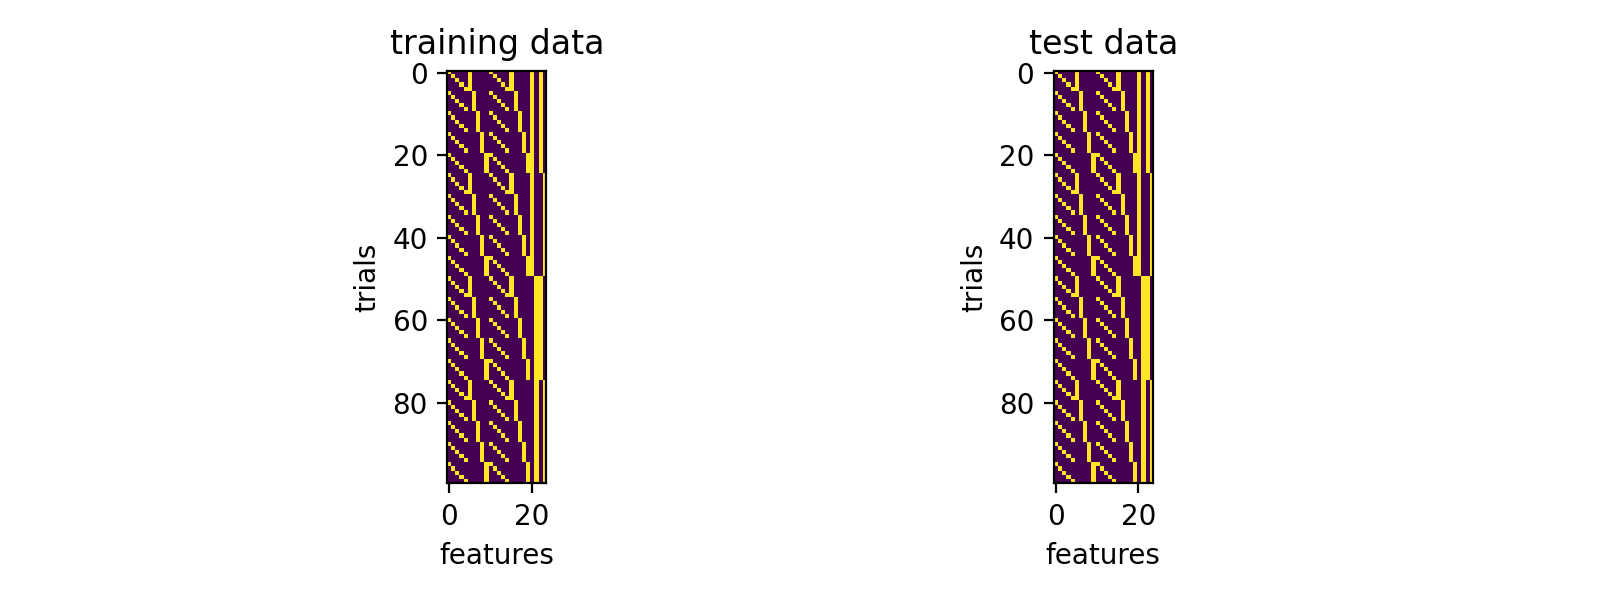

In [14]:
%matplotlib notebook
x,y,xt,yt = mk_experiment()
plt.figure(figsize=(8,3));
plt.subplot(1,2,1)
plt.imshow(x)
plt.title('training data')
plt.xlabel('features')
plt.ylabel('trials')
plt.subplot(1,2,2)
plt.imshow(xt)
plt.title('test data')
plt.xlabel('features')
plt.ylabel('trials')
plt.tight_layout()

In [7]:
def taskaccuracy(x,y,model):    
    yo = model(x)
    #print(yo[:25,:].shape)
    #print(y[:25,:].shape)
    # 1st task
    acc1_1 = accuracy(yo[:25,:],y[:25,:]).detach().numpy()
    acc1_2 = accuracy(yo[25:50,:],y[25:50,:]).detach().numpy()
    acc2_1 = accuracy(yo[50:75,:],y[50:75,:]).detach().numpy()
    acc2_2 = accuracy(yo[75:,:],y[75:,:]).detach().numpy()
    return acc1_1,acc1_2, acc2_1,acc2_2
   
def choicemat(x,model):
    _,_,yo = model.get_activity(x)
    mat1_1 = yo[:25,:].reshape((5,5))
    mat1_2 = yo[25:50,:].reshape((5,5))
    mat2_1 = yo[50:75,:].reshape((5,5))
    mat2_2 = yo[75:,:].reshape((5,5))
    return mat1_1,mat1_2,mat2_1,mat2_2

def save_data(fn):
    with open('./results/' + fn,'wb') as f:    
        pickle.dump([acc1_1s, acc1_2s, acc2_1s, acc2_2s, mat1_1s, mat1_2s, mat2_1s, mat2_2s, rdmsh1, rdmsh2], f)

In [11]:
acc1_1s = []
acc1_2s = []
acc2_1s = []
acc2_2s = []
mat1_1s = []
mat1_2s = []
mat2_1s = []
mat2_2s = []
rdmsh1 = []
rdmsh2 = []

for i in range(num_runs):
    # get data
    x_train,y_train,x_test,y_test = map(torch.tensor, mk_experiment_rand())
    # # instantiate model
    nnet, opt = get_model()
    # # train on task
    l,a = fit(nnet,disp=True)

    # run this to get the data for the analysis section below
    acc1_1,acc1_2,acc2_1,acc2_2,mat1_1,mat1_2,mat2_1,mat2_2,rdm1, rdm2 = evaluate(x_test,y_test,nnet)
    acc1_1s.append(acc1_1)
    acc1_2s.append(acc1_2)
    acc2_1s.append(acc2_1)
    acc2_2s.append(acc2_2)
    mat1_1s.append(mat1_1)
    mat1_2s.append(mat1_2)
    mat2_1s.append(mat2_1)
    mat2_2s.append(mat2_2)
    rdmsh1.append(rdm1)
    rdmsh2.append(rdm2)
    
acc1_1s = np.array(acc1_1s)
acc1_2s = np.array(acc1_2s)
acc2_1s = np.array(acc2_1s)
acc2_2s = np.array(acc2_2s)
mat1_1s = np.array(mat1_1s)
mat1_2s = np.array(mat1_2s)
mat2_1s = np.array(mat2_1s)
mat2_2s = np.array(mat2_2s)
rdmsh1 = np.array(rdmsh1)
rdmsh2 = np.array(rdmsh2)

iteration 0, MSE 2.0080366134643555, accuracy 0.20000000298023224
iteration 1000, MSE 1.5877766609191895, accuracy 0.20000000298023224
iteration 2000, MSE 0.41147109866142273, accuracy 0.44999998807907104
iteration 3000, MSE 0.001009844127111137, accuracy 1.0
iteration 4000, MSE 4.872190856985981e-06, accuracy 1.0
iteration 0, MSE 2.028867483139038, accuracy 0.20000000298023224
iteration 1000, MSE 1.8158093690872192, accuracy 0.20000000298023224
iteration 2000, MSE 0.7484161257743835, accuracy 0.41999998688697815
iteration 3000, MSE 0.006356249563395977, accuracy 1.0
iteration 4000, MSE 2.6228222850477323e-05, accuracy 1.0
iteration 0, MSE 2.01252818107605, accuracy 0.20000000298023224
iteration 1000, MSE 1.7522473335266113, accuracy 0.20000000298023224
iteration 2000, MSE 0.658437967300415, accuracy 0.4300000071525574
iteration 3000, MSE 0.0012359031243249774, accuracy 1.0
iteration 4000, MSE 7.328827678065863e-07, accuracy 1.0
iteration 0, MSE 2.2771854400634766, accuracy 0.200000002

In [13]:
save_data('2tsk_2cxt_randortho')

In [30]:
for i in range(num_runs):
    print(" Accuracy run: {} Dangerousness Task: animals: {}, objects: {}, Size Task: animals: {}, objects: {}".format(i,acc1_1,acc1_2,acc2_1,acc2_2))

 Accuracy run: 0 Dangerousness Task: animals: 1.0, objects: 1.0, Size Task: animals: 1.0, objects: 1.0


<IPython.core.display.Javascript object>


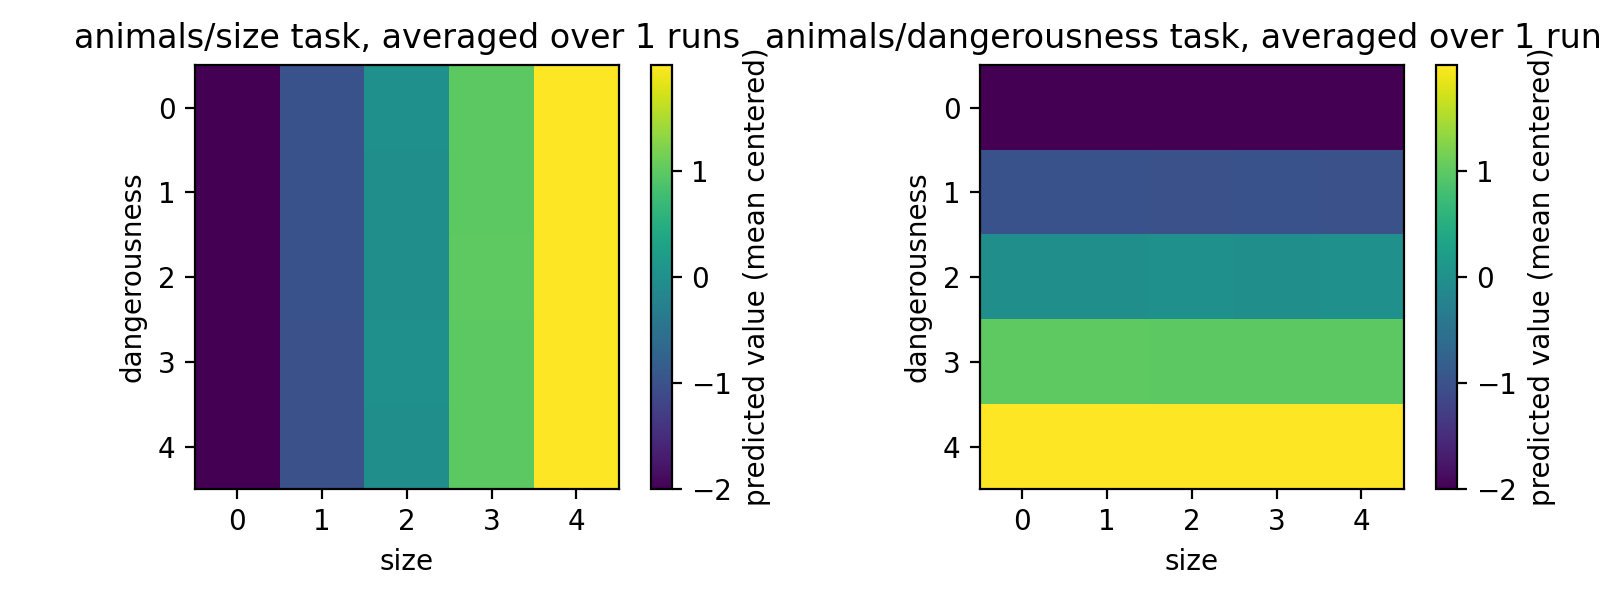

<IPython.core.display.Javascript object>


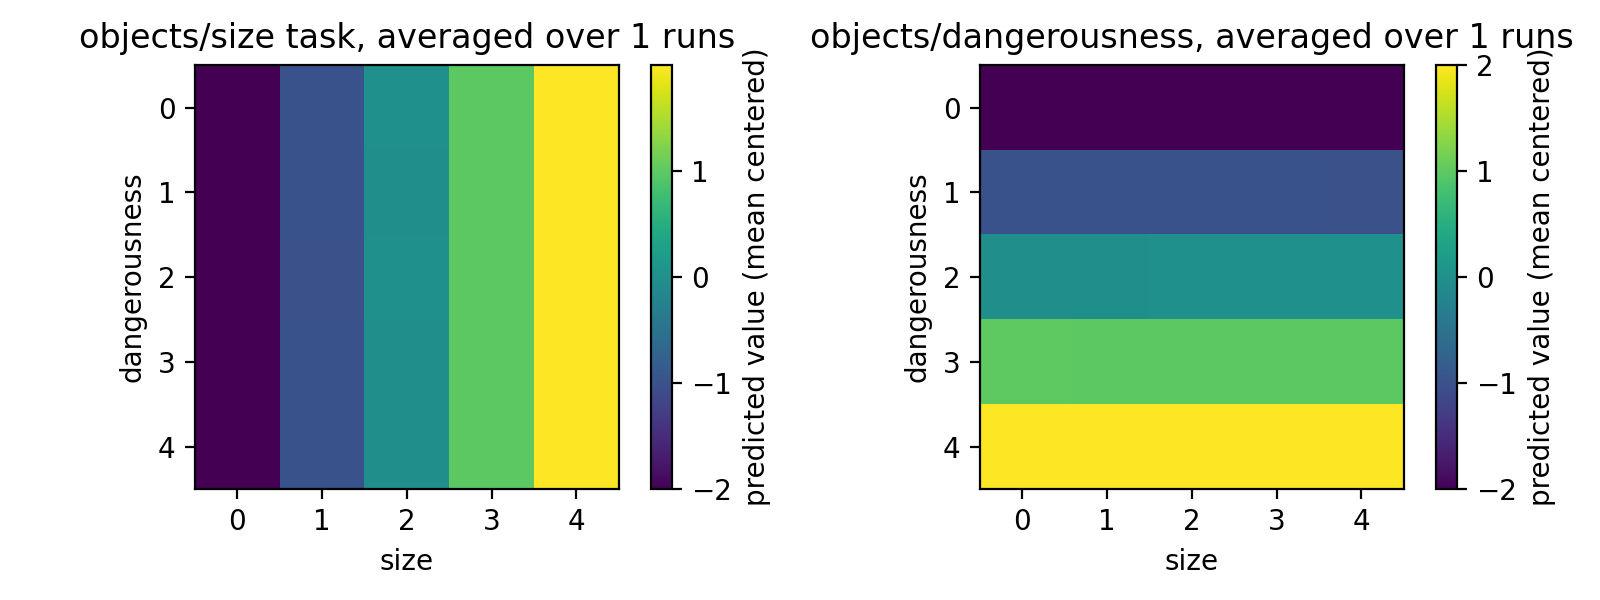

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(mat1_1s,0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('animals/size task, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.subplot(1,2,2)
plt.imshow(np.mean(mat2_1s,0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('animals/dangerousness task, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.tight_layout()

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(mat1_2s,0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('objects/size task, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.subplot(1,2,2)
plt.imshow(np.mean(mat2_2s, 0))
plt.xlabel('size')
plt.ylabel('dangerousness')
plt.title('objects/dangerousness, averaged over {} runs'.format(num_runs))
plt.colorbar(label='predicted value (mean centered)')
plt.tight_layout()

<IPython.core.display.Javascript object>


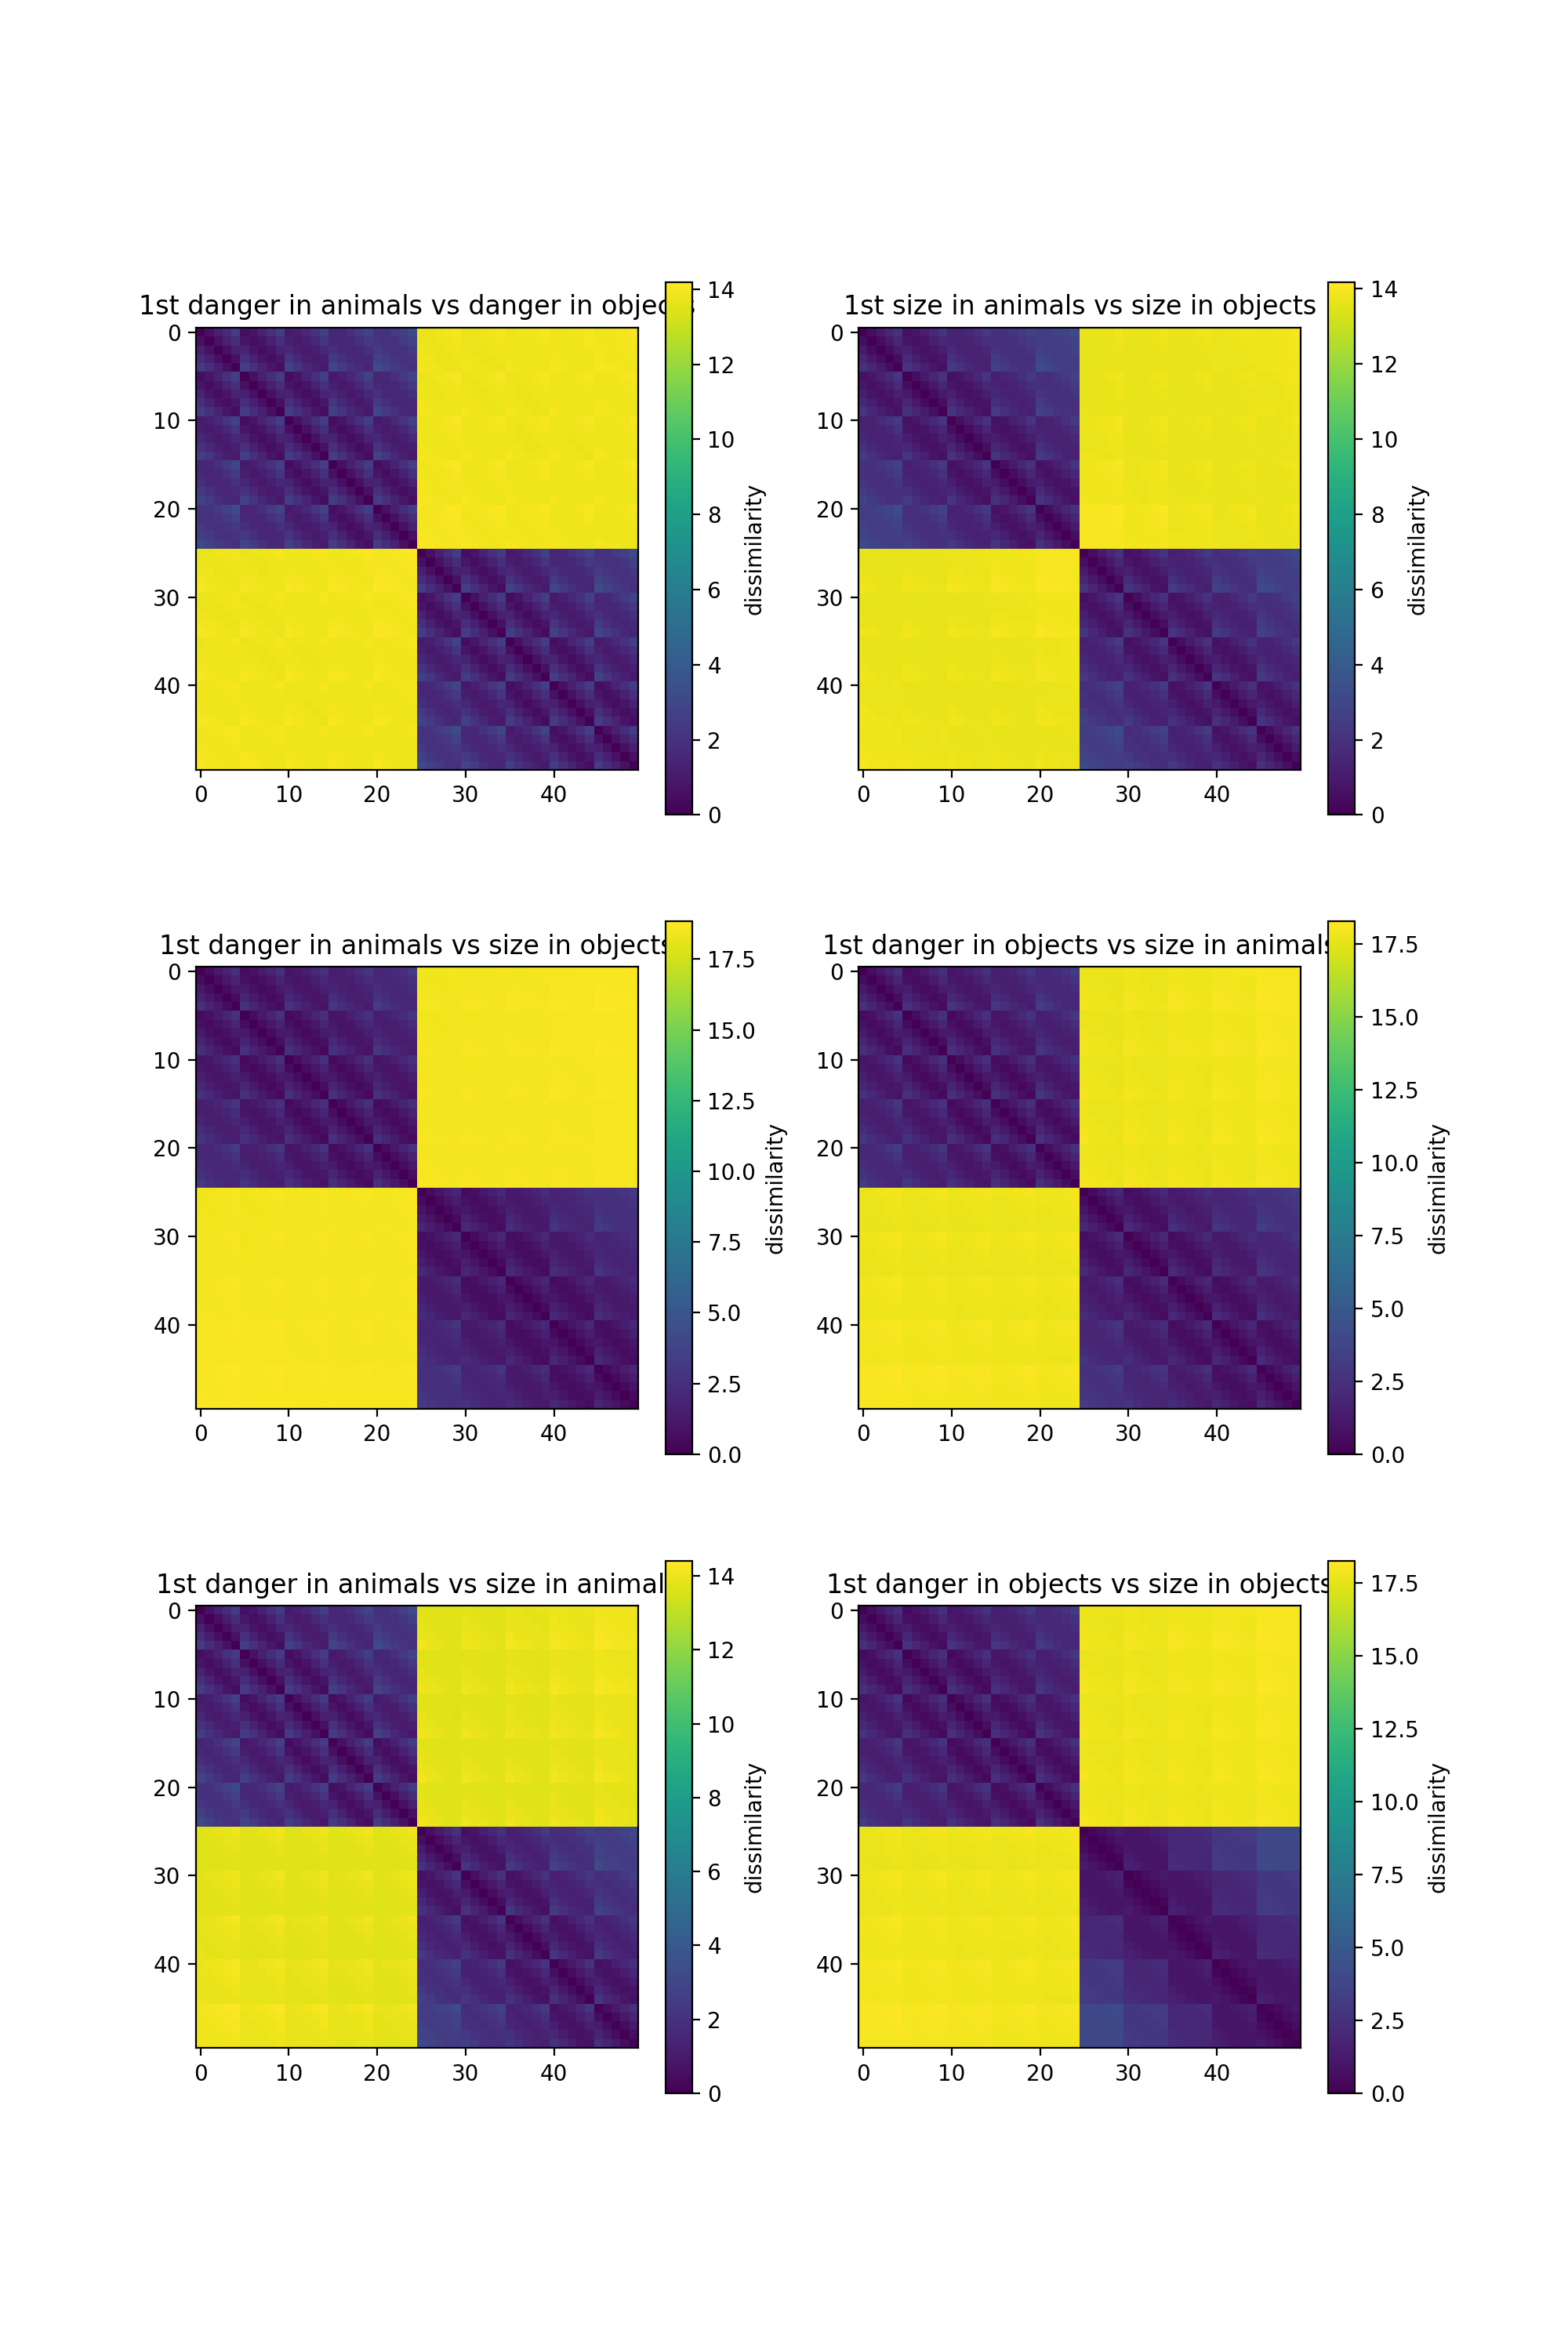

<IPython.core.display.Javascript object>


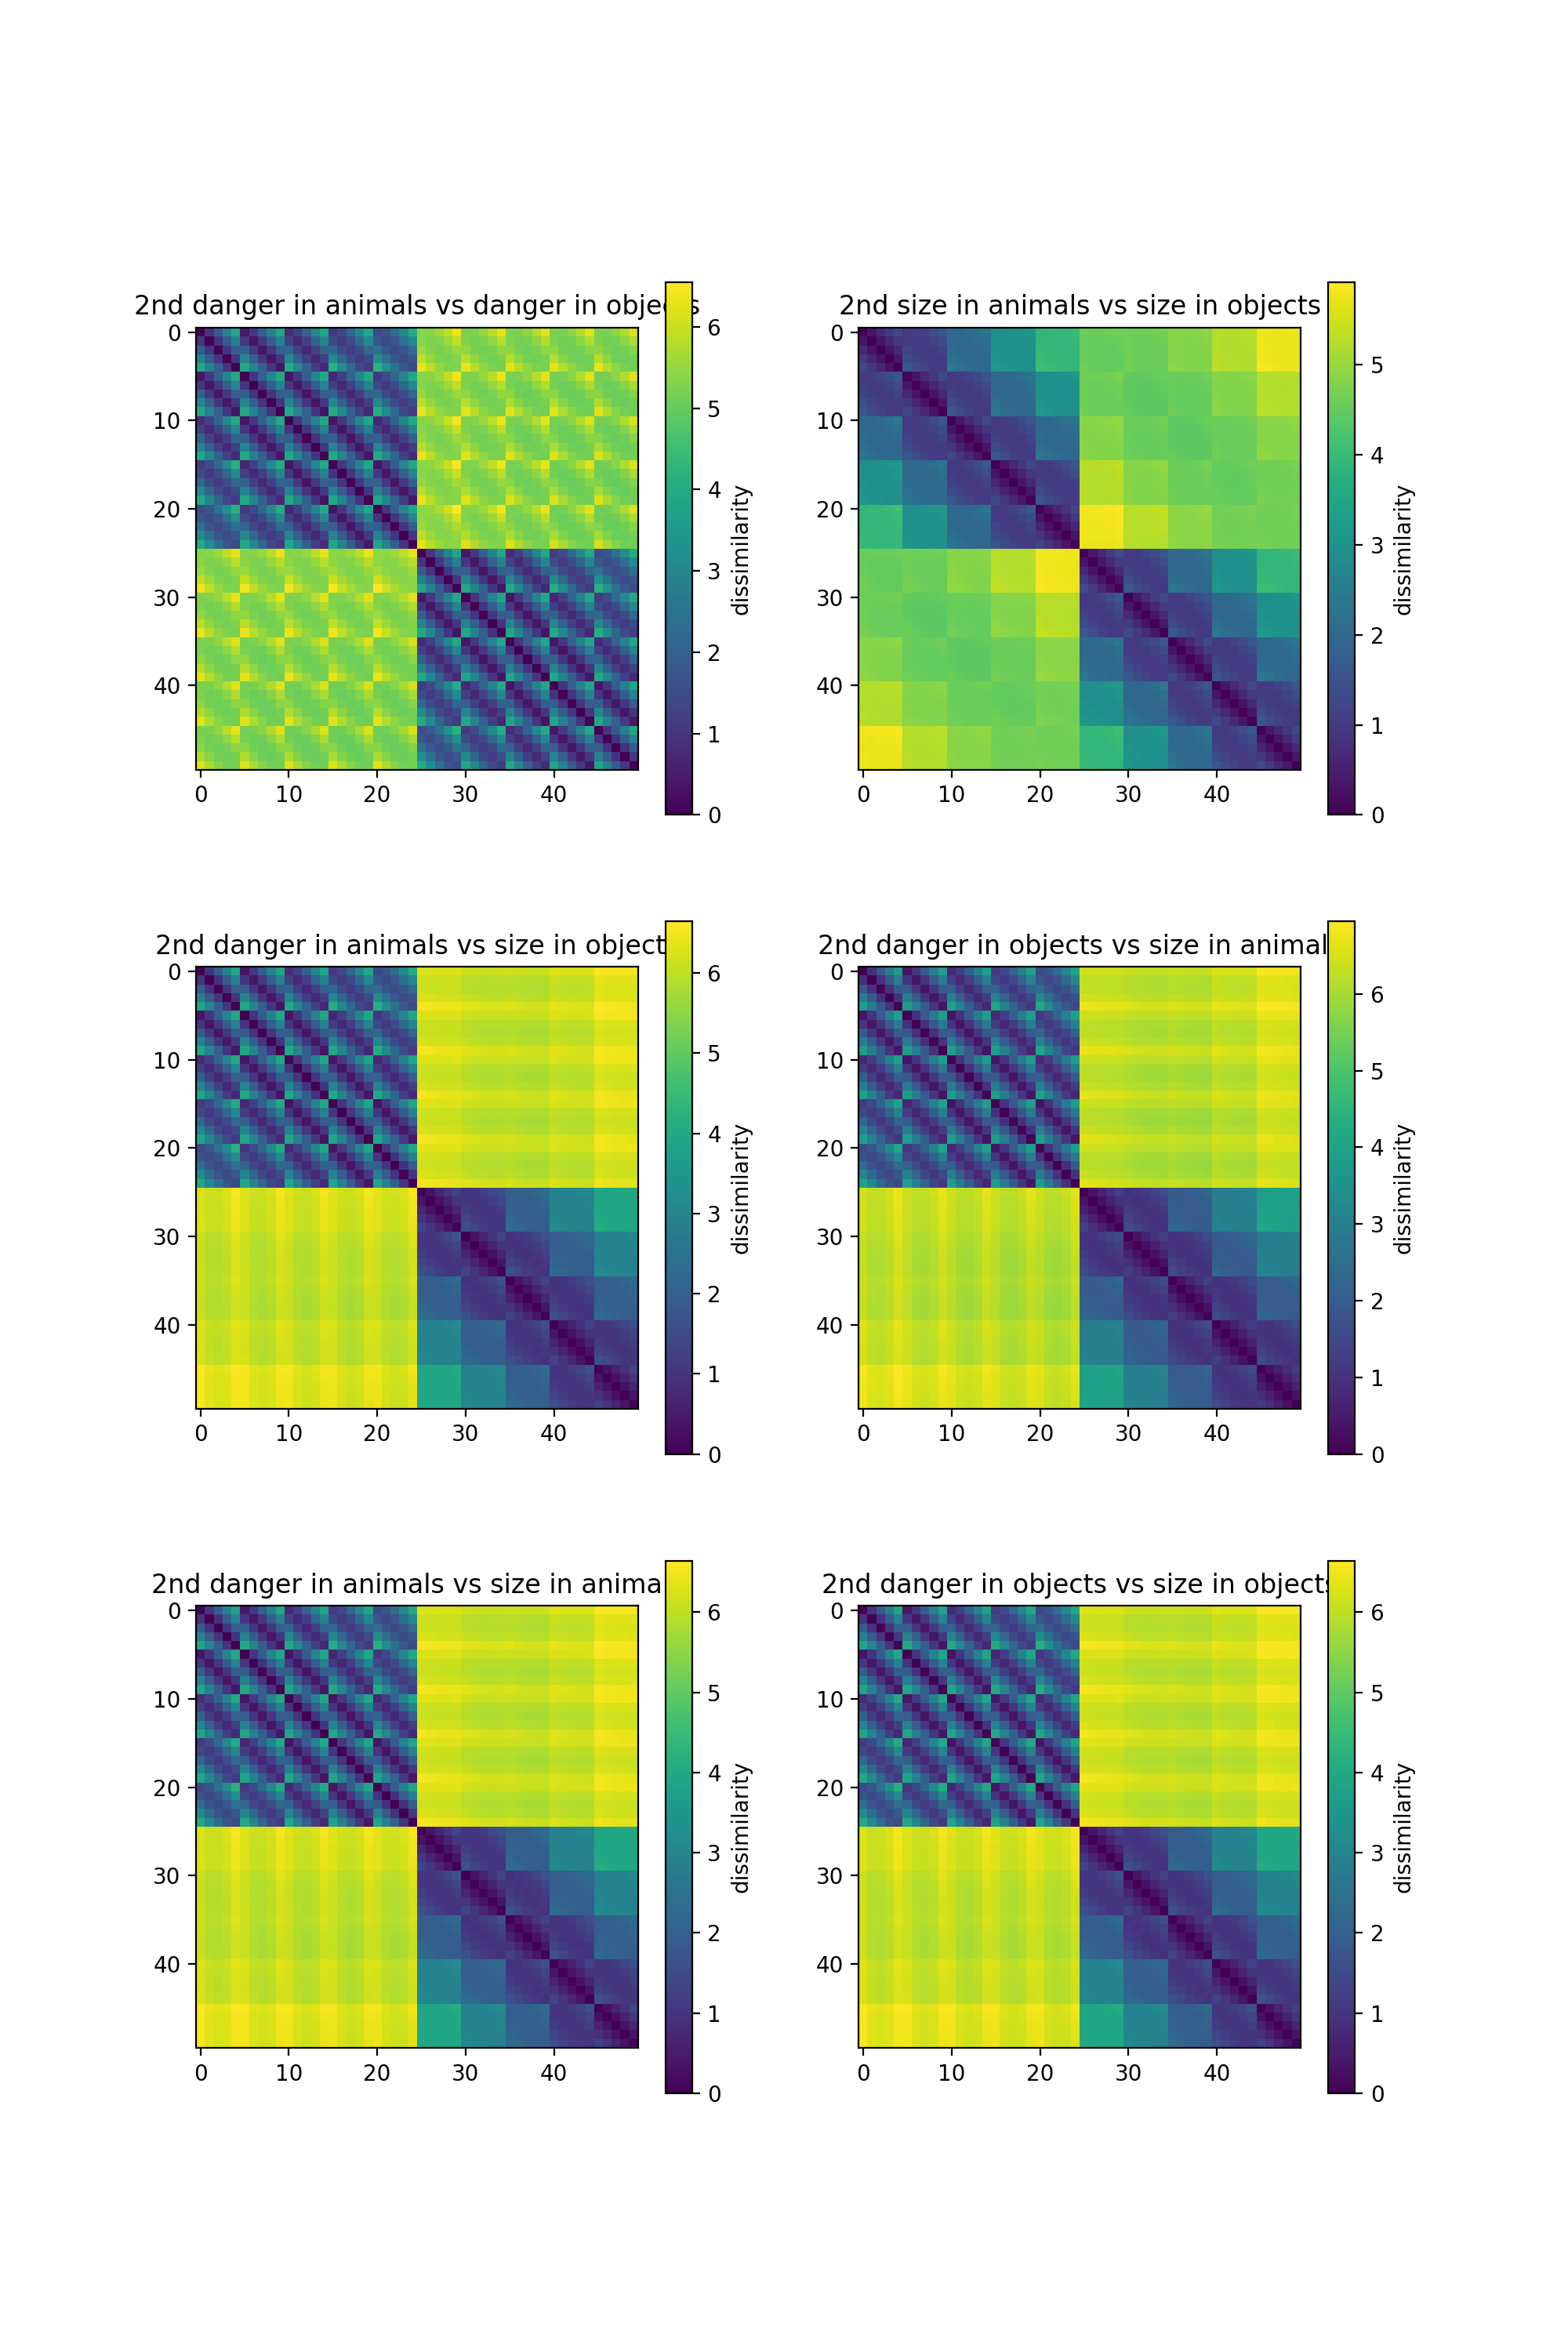

Text(0.5, 1.0, '2nd danger in objects vs size in objects')

In [19]:
meanrdmh1 = np.mean(rdmsh1,0)
meanrdmh2 = np.mean(rdmsh2,0)

h1da_db = meanrdmh1[:50,:50]
    
h1sa_sb = meanrdmh1[50:,50:]    

h1da_sb1 = np.concatenate([meanrdmh1[:25,:25], meanrdmh1[:25,75:]], axis=1)
h1da_sb2 = np.concatenate([meanrdmh1[75:,:25], meanrdmh1[75:,75:]], axis=1)
h1da_sb = np.concatenate([h1da_sb1, h1da_sb2], axis=0)    

h1db_sa = meanrdmh1[25:75, 25:75]

h1da_sa1 = np.concatenate([meanrdmh1[:25,:25], meanrdmh1[:25,50:75]], axis=1)
h1da_sa2 = np.concatenate([meanrdmh1[50:75,:25], meanrdmh1[50:75,50:75]], axis=1)
h1da_sa = np.concatenate([h1da_sa1, h1da_sa2], axis=0)

h1db_sb1 = np.concatenate([meanrdmh1[25:50,25:50], meanrdmh1[25:50,50:75]], axis=1)
h1db_sb2 = np.concatenate([meanrdmh1[50:75,25:50], meanrdmh2[50:75,50:75]], axis=1)
h1db_sb = np.concatenate([h1db_sb1, h1db_sb2], axis=0)

plt.figure(figsize=(10,15))
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.subplot(3,2,1)
plt.imshow(h1da_db)
plt.colorbar(label='dissimilarity')
plt.title('1st danger in animals vs danger in objects')

plt.subplot(3,2,2)
plt.imshow(h1sa_sb)
plt.colorbar(label='dissimilarity')
plt.title('1st size in animals vs size in objects')

plt.subplot(3,2,3)
plt.imshow(h1da_sb)
plt.colorbar(label='dissimilarity')
plt.title('1st danger in animals vs size in objects')

plt.subplot(3,2,4)
plt.imshow(h1db_sa)
plt.colorbar(label='dissimilarity')
plt.title('1st danger in objects vs size in animals')

plt.subplot(3,2,5)
plt.imshow(h1da_sa)
plt.colorbar(label='dissimilarity')
plt.title('1st danger in animals vs size in animals')

plt.subplot(3,2,6)
plt.imshow(h1db_sb)
plt.colorbar(label='dissimilarity')
plt.title('1st danger in objects vs size in objects')


h2da_db = meanrdmh2[:50,:50]
    
h2sa_sb = meanrdmh2[50:,50:]    

h2da_sb1 = np.concatenate([meanrdmh2[:25,:25], meanrdmh2[:25,75:]], axis=1)
h2da_sb2 = np.concatenate([meanrdmh2[75:,:25], meanrdmh2[75:,75:]], axis=1)
h2da_sb = np.concatenate([h2da_sb1, h2da_sb2], axis=0)    

h2db_sa = meanrdmh2[25:75, 25:75]

h2da_sa1 = np.concatenate([meanrdmh2[:25,:25], meanrdmh2[:25,50:75]], axis=1)
h2da_sa2 = np.concatenate([meanrdmh2[50:75,:25], meanrdmh2[50:75,50:75]], axis=1)
h2da_sa = np.concatenate([h2da_sb1, h2da_sb2], axis=0)

h2db_sb1 = np.concatenate([meanrdmh2[25:50,25:50], meanrdmh2[25:50,50:75]], axis=1)
h2db_sb2 = np.concatenate([meanrdmh2[50:75,25:50], meanrdmh2[50:75,50:75]], axis=1)
h2db_sb = np.concatenate([h2da_sb1, h2da_sb2], axis=0)

plt.figure(figsize=(10,15))
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.subplot(3,2,1)
plt.imshow(h2da_db)
plt.colorbar(label='dissimilarity')
plt.title('2nd danger in animals vs danger in objects')

plt.subplot(3,2,2)
plt.imshow(h2sa_sb)
plt.colorbar(label='dissimilarity')
plt.title('2nd size in animals vs size in objects')

plt.subplot(3,2,3)
plt.imshow(h2da_sb)
plt.colorbar(label='dissimilarity')
plt.title('2nd danger in animals vs size in objects')

plt.subplot(3,2,4)
plt.imshow(h2db_sa)
plt.colorbar(label='dissimilarity')
plt.title('2nd danger in objects vs size in animals')

plt.subplot(3,2,5)
plt.imshow(h2da_sa)
plt.colorbar(label='dissimilarity')
plt.title('2nd danger in animals vs size in animals')

plt.subplot(3,2,6)
plt.imshow(h2db_sb)
plt.colorbar(label='dissimilarity')
plt.title('2nd danger in objects vs size in objects')

<IPython.core.display.Javascript object>


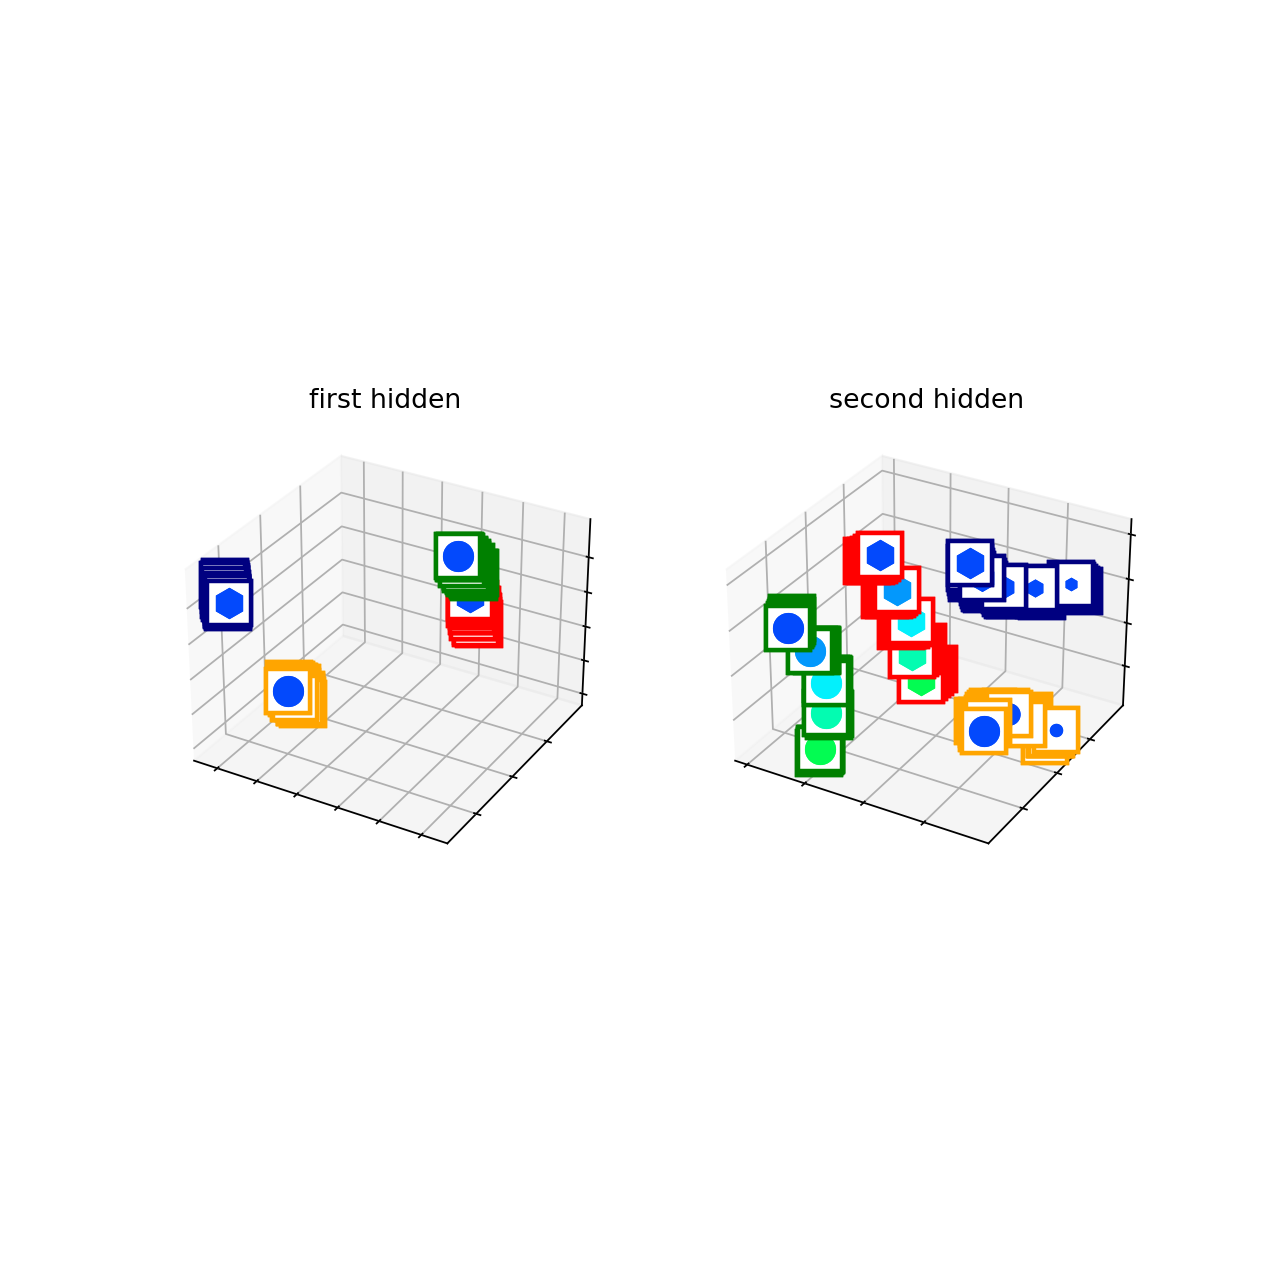

Text(0.5, 0.92, 'second hidden')

In [12]:
%matplotlib notebook
embedding = MDS(n_components=3, dissimilarity='precomputed')
fig=plt.figure(10+i,figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
# xyz = embedding.fit_transform(rdm)
xyz = embedding.fit_transform(np.mean(rdmsh1,0))
ax = fig.add_subplot(1,2,1, projection='3d')
plot_grid3(xyz[:25,:],line_colour=(0,0,.5),line_width=2,fig_id=10+i)
plot_grid3(xyz[25:50,:],line_colour='orange',line_width=2,fig_id=10+i)
plot_grid3(xyz[50:75,:],line_colour='red',line_width=2,fig_id=10+i)
plot_grid3(xyz[75:,:],line_colour='green',line_width=2,fig_id=10+i)
scatter_mds_3(xyz,task_id='four',fig_id=10+i)   
plt.title('first hidden')

xyz = embedding.fit_transform(np.mean(rdmsh2,0))
ax = fig.add_subplot(1,2,2, projection='3d')
plot_grid3(xyz[:25,:],line_colour=(0,0,.5),line_width=2,fig_id=10+i)
plot_grid3(xyz[25:50,:],line_colour='orange',line_width=2,fig_id=10+i)
plot_grid3(xyz[50:75,:],line_colour='red',line_width=2,fig_id=10+i)
plot_grid3(xyz[75:,:],line_colour='green',line_width=2,fig_id=10+i)
scatter_mds_3(xyz,task_id='four',fig_id=10+i)   
plt.title('second hidden')